# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import matplotlib
import numpy as np
import cv2
import tensorflow as tf
import random

# Load pickled data
training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_file, y_train_file = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Done!")

Done!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [20]:
### Replace each question mark with the appropriate value.

n_train = X_train_file.shape[0]

n_test = X_test.shape[0]

image_shape = X_train_file[0].shape

n_classes = len(np.unique(y_train_file))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

signnames = np.loadtxt('./signnames.csv',
                      delimiter=',',
                      skiprows=1,
                      dtype={'names': ('ClassId', 'SignName'),'formats': ('i4', 'S100')})

print("Done!")

Number of training examples = 117627
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Done!


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

> First we try to visualize some samples in the training dataset. We take randonmly 6 and verify that their label assigned is correctly matched.

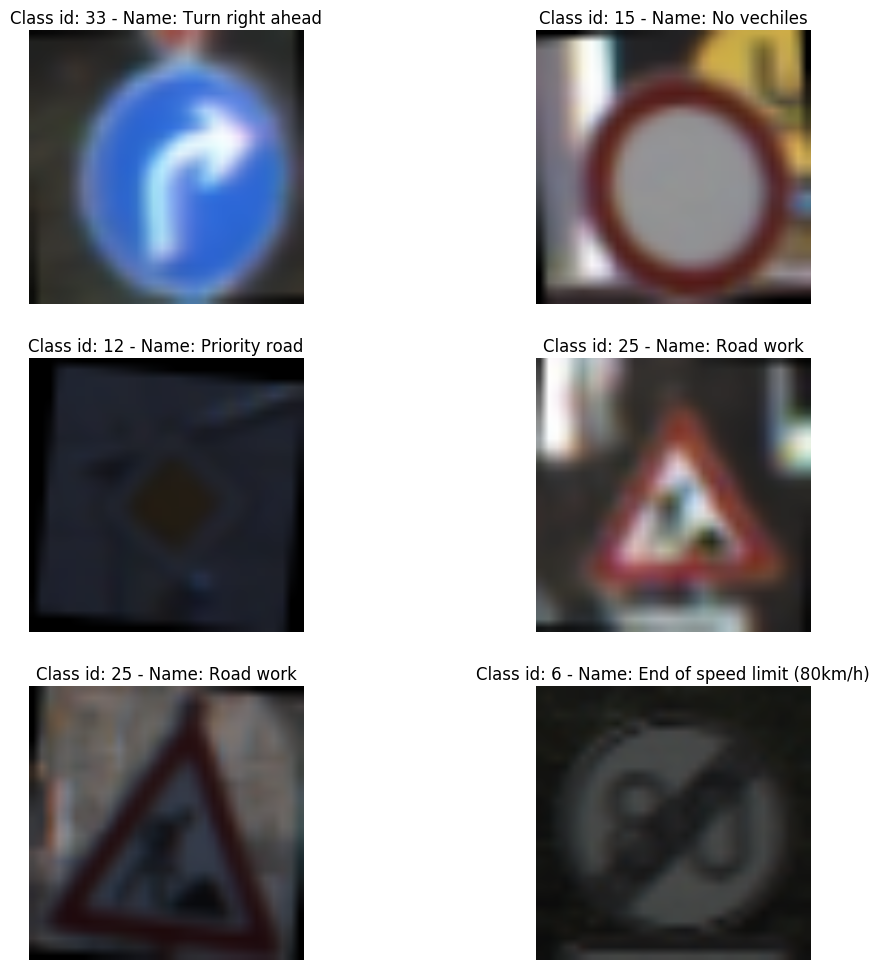

In [34]:
# Visualizing random samples
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

gs1 = gridspec.GridSpec(3, 2)
#gs1.update(wspace=10, hspace=5) # set the spacing between axes.
plt.figure(figsize=(12,12))

n_samples = 6
i = 0
for index in np.random.choice(n_train, n_samples):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.set_title("Class id: {} - Name: {}".format(class_id, name.decode()))

    img = X_train_file[index]
    class_id, name = signnames[y_train_file[index]]
    plt.title("Class id: {} - Name: {}".format(class_id, name.decode()))
    i += 1
    plt.imshow(img)
    plt.axis('off')

plt.show()

> Next, we plot an histogram of counts of observations per class. This visualization helps us to have an idea of what the distribution is so that we can later decide if it is necessary to *artificially* grow the dataset to train our model.
>
> As we observe, there are some classes with very low counts. For example, there are only 210 observations for class 0 ( Speed limit 20 kms/h).
> Giving this visualization, we decided to try some techniques to grown the dataset. More on this, later.

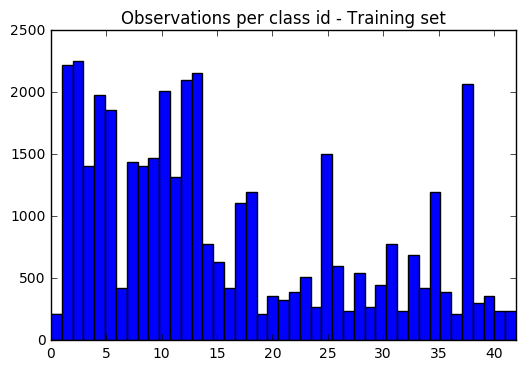

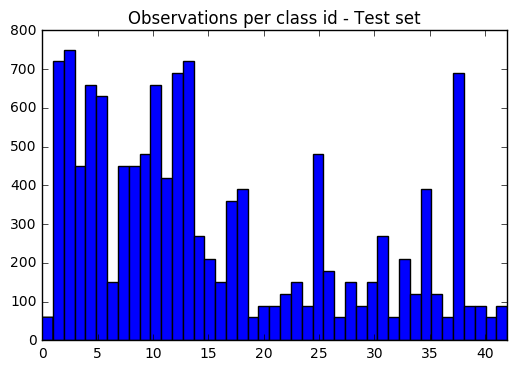

In [5]:
# count of samples per class in training set
plt.xlim([0, n_classes - 1])
plt.hist(y_train_file, bins=n_classes)
plt.title("Observations per class id - Training set")
plt.show()

plt.xlim([0, n_classes - 1])
plt.hist(y_test, bins=n_classes)
plt.title("Observations per class id - Test set")
plt.show()

> The following code simply computes some counters per class that will helps us in our techniques of growing the test dataset.

In [35]:
# counts
label_indexes = {}

for label_class in range(n_classes):
    label_indexes[label_class] = []
    
for idx in range(len(y_train_file)):
    label = y_train_file[idx]
    label_indexes[label].append(idx)

counts_per_class = [len(label_indexes[x]) for x in range(n_classes)]
max_samples_per_class = max(counts_per_class)
avg_samples_per_class = int(sum(counts_per_class)/len(counts_per_class))
print(counts_per_class, max_samples_per_class)

[630, 6660, 6750, 4230, 5940, 5580, 1260, 4320, 4230, 4410, 6030, 3960, 6300, 6480, 2340, 1890, 1260, 3330, 3600, 630, 1080, 990, 1170, 1530, 810, 4500, 1800, 720, 1620, 810, 1350, 2340, 720, 2067, 1260, 3600, 1170, 630, 6210, 900, 1080, 720, 720] 6750


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
# NOTICE: ALL THE CODE IN THIS CELL IS BASED ON : https://github.com/vxy10/ImageAugmentation

def augment_brightness_camera_images(img):
    image1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

In [36]:
def generate_samples(class_label, num_samples):
    new_images = np.zeros((num_samples, 32, 32, 3), dtype=np.uint8)
    for sample in range(num_samples):
        rnd_idx = random.choice(label_indexes[class_label])
        new_images[sample] = transform_image(X_train_file[rnd_idx], 10, 5, 5, brightness=1) #20, 10, 5
    return new_images, num_samples*[class_label]

MATCH_MAX_OBSERVATIONS = False

if (MATCH_MAX_OBSERVATIONS):
    for class_label in range(n_classes):
        needed_samples = max_samples_per_class - counts_per_class[class_label]
        if (needed_samples < 1):
            continue
        print("generating {} samples for classs : {}".format(needed_samples, signnames[class_label][1].decode()))
        (new_images, new_labels) = generate_samples(class_label, needed_samples)
        X_train_file = np.vstack((X_train_file, new_images))
        y_train_file = np.hstack((y_train_file, new_labels))

    print(X_train_file.shape)
    print(y_train_file.shape)
    print("Done!")

    # count of samples per class in training set
    plt.xlim([0, n_classes - 1])
    plt.hist(y_train_file, bins=n_classes)
    plt.title("Observations per class id - Training set")
    plt.show()


In [9]:
# generating artificial images
rotation_degrees = range(-15, 16)
scaling_factors = [0.9, 0.95, 1.0, 1.05, 1.1]

def  scale_and_crop(img, factor):
    if (factor == 1.0):
        return img
    new_img = cv2.resize(img, None,fx=factor, fy=factor, interpolation = cv2.INTER_AREA)
    size = new_img.shape[0]
    if size < 32:
        right_pad = int((32 - size)/2)
        left_pad = right_pad + (size & 1)
        new_img = np.pad(new_img, ((left_pad, right_pad), (left_pad, right_pad), (0, 0)), 'constant')
    else:
        # crop the image to 32x32xC            
        start = (size - 32)/2
        end = start + 32
        new_img = new_img[start:end, start:end]
    return new_img

def rotate(img, degrees):
    (cols, rows, _) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(img, M, (cols, rows))

def generateDataSet(images):
    new_images = images.copy()
    for idx in range(images.shape[0]):
        scaling = random.choice(scaling_factors)
        angle = random.choice(rotation_degrees)
        scaled_img = scale_and_crop(images[idx], scaling)
        rotated_img = rotate(scaled_img, angle)
        new_images[idx] = rotated_img
    return new_images

def reproduceDataSet(images, labels, copies):
    orig_images = images.copy()
    orig_labels = labels.copy()
    for i in range(copies):
        images = np.vstack((images, generateDataSet(orig_images)))
        labels = np.hstack((labels, orig_labels))
    return images, labels

(X_train_jitt, y_train_jitt) = reproduceDataSet(X_train_file, y_train_file, 2)

print(X_train_file.shape)
print(y_train_file.shape)
print(X_train_jitt.shape)
print(y_train_jitt.shape)

y_train_file = y_train_jitt
X_train_file = X_train_jitt

print("Done!")

/Users/vm.guerramoran/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(39209, 32, 32, 3)
(39209,)
(117627, 32, 32, 3)
(117627,)
Done!


In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# proprocessing images
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def img_norm(img):
    img_dst = img.copy()
    return cv2.normalize(img, dst=img_dst, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

def images_to_gray(images):
    shape = images.shape
    copy = np.zeros((shape[0], shape[1], shape[2]))
    for idx in range(images.shape[0]):
        copy[idx] = rgb2gray(images[idx])
    return copy

# preprocessing dataset
def normalize_images(images):
    shape = images.shape
    copy = np.zeros((shape[0], shape[1], shape[2]))
    for idx in range(images.shape[0]):
        copy[idx] = img_norm(images[idx])
    return copy

def preprocess(images):
    pp = normalize_images(images_to_gray(images))
    return np.reshape(pp, pp.shape + (1, ))

X_train_pp = preprocess(X_train_file)
X_test = preprocess(X_test)

print(X_train_pp.shape)

print("Done!")

(117627, 32, 32, 1)
Done!


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_pp, y_train_file, test_size=0.3, random_state=42)

print("Training set shape: {}".format(X_train.shape))
print("Validation set shape: {}".format(X_validation.shape))
print("Test set shape: {}".format(X_test.shape))

Training set shape: (82338, 32, 32, 1)
Validation set shape: (35289, 32, 32, 1)
Test set shape: (12630, 32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

# German Traffic Sign Classifier
def GTSC(x, n_classes, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # returns all parameters 
    all_parameters = []
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, all_parameters)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Trainning w/82338 observations
EPOCH 1 ...
Training Accuracy = 0.559
Validation Accuracy = 0.578
Validation loss = 1.448

EPOCH 2 ...
Training Accuracy = 0.706
Validation Accuracy = 0.767
Validation loss = 0.764

EPOCH 3 ...
Training Accuracy = 0.912
Validation Accuracy = 0.877
Validation loss = 0.404

EPOCH 4 ...
Training Accuracy = 0.941
Validation Accuracy = 0.926
Validation loss = 0.258

EPOCH 5 ...
Training Accuracy = 0.971
Validation Accuracy = 0.941
Validation loss = 0.198

EPOCH 6 ...
Training Accuracy = 0.971
Validation Accuracy = 0.950
Validation loss = 0.172

EPOCH 7 ...
Training Accuracy = 0.941
Validation Accuracy = 0.956
Validation loss = 0.150

EPOCH 8 ...
Training Accuracy = 1.000
Validation Accuracy = 0.964
Validation loss = 0.126

EPOCH 9 ...
Training Accuracy = 1.000
Validation Accuracy = 0.962
Validation loss = 0.129

EPOCH 10 ...
Training Accuracy = 1.000
Validation Accuracy = 0.965
Validation loss = 0.124

EPOCH 11 ...
Training Accuracy = 0.971
Validation Accuracy

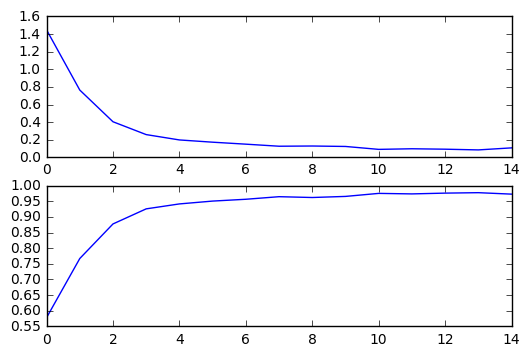

In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 15
BATCH_SIZE = 128

# Regularization
regParam = 0.0001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

rate = 0.001
(logits, all_parameters) = GTSC(x, n_classes, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy + sum([regParam*tf.nn.l2_loss(param) for param in all_parameters]))

optimizer = tf.train.AdamOptimizer(learning_rate = rate,
                                            beta1=0.9,
                                            beta2=0.999,
                                            epsilon=1e-08,
                                            use_locking=False,
                                            name='Adam')
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

validation_accurracies = []
validation_losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]

    print("Trainning w/{} observations".format(num_examples))
    
    for i in range(EPOCHS):
        X, Y = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X[offset:end], Y[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        (training_accuracy, training_loss) = evaluate(batch_x, batch_y)
        (validation_accuracy, validation_loss) = evaluate(X_validation, y_validation)
        validation_accurracies.append(validation_accuracy)
        validation_losses.append(validation_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, 'tsc')
    print("Model saved")

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(range(EPOCHS), validation_losses)

ax2 = fig.add_subplot(212)
ax2.plot(range(EPOCHS), validation_accurracies)

plt.show()

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, _ = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.936


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import os
import re


photos = glob.glob('./imgs/*.jpg')
pattern = re.compile('([0-9]+)_(.*)')

X_custom_test = np.zeros((len(photos), 32, 32, 1))
y_custom_test = []

for (idx, filepath) in enumerate(photos):
    filename = os.path.split(filepath)[-1]
    label = pattern.match(filename).group(1)
    y_custom_test.append(int(label))
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))
    X_custom_test[idx] = np.reshape(img, img.shape + (1, ))

print(X_custom_test.shape)
print(y_custom_test)

print("Done!")

(5, 32, 32, 1)
[25, 28, 2, 31, 33]
Done!


1500


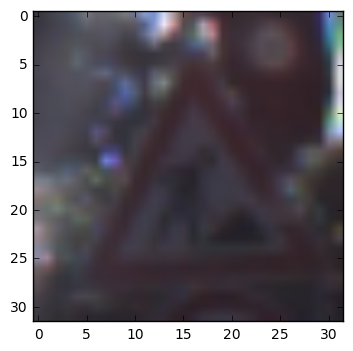

In [16]:
print(len(label_indexes[25]))
idx = label_indexes[25][900]
img = X_train_file[idx]
plt.imshow(img)

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    sess = tf.get_default_session()
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 3), feed_dict={x: X_custom_test, y: y_custom_test, keep_prob : 1.0})
    print(top_k)
#     prediction = sess.run(tf.argmax(logits, 1),
#                               feed_dict={x: X_custom_test, y: y_custom_test, keep_prob : 1.0})
#     print(logits)
#     for idx in range(len(prediction)):
#         img = np.reshape(X_custom_test[idx], (32, 32))
#         plt.imshow(img, cmap='gray')
#         real_id = y_custom_test[idx]
#         predicted_id = prediction[idx]
#         plt.title("Real Class:  {} - {} | Predicted Class: {} - {}".format(
#                 real_id,
#                 signnames[real_id][1].decode(),
#                 predicted_id,
#                 signnames[predicted_id][1].decode()))
                  
#         plt.figure()
#     plt.show()
    
    print(y_custom_test)
    test_accuracy, loss = evaluate(X_custom_test, y_custom_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

TopKV2(values=array([[  1.00000000e+00,   2.34428033e-11,   4.27455956e-14],
       [  9.99999881e-01,   1.36898407e-07,   4.14897849e-09],
       [  1.00000000e+00,   1.44361837e-16,   7.21363145e-20],
       [  1.00000000e+00,   5.10548461e-12,   1.31151546e-22],
       [  9.99999523e-01,   4.82208179e-07,   5.03081572e-13]], dtype=float32), indices=array([[25, 20, 23],
       [28, 29, 30],
       [ 2,  5,  1],
       [31, 21, 10],
       [33,  4,  1]], dtype=int32))
[25, 28, 2, 31, 33]
Test Accuracy = 1.000


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.